## Logistic Regression && XGBoost Model

A logistic regression model is a type of statistical model used for binary classification tasks. Unlike linear regression, which predicts a continuous outcome, logistic regression predicts the probability of a binary outcome (i.e., a categorical outcome with two possible values such as 0/1, true/false, yes/no).

XGBoost (eXtreme Gradient Boosting) is an optimized and scalable implementation of gradient boosting, a machine learning technique used for classification and regression tasks. It is designed to be efficient, flexible, and portable, offering a range of enhancements over traditional gradient boosting techniques, such as regularization, parallel processing, and handling missing values.

In [ ]:
%pip install polars
%pip install pyarrow
%pip install imbalanced-learn
%pip install xgboost
%pip install imbalanced-learn

In [42]:
#import necessary libraries
import sys
import pyarrow
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import cm
import numpy as np
import polars as pl
import pandas as pd
from glob import glob
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import learning_curve
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from random import randint, uniform
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')
# Append the directory containing `merge_tools.py` to the Python path
sys.path.append('../notebooks/utils/')
from utils.merge_tools import merge_n_case_ids

In [22]:
# Importing functions from merge_tools.py
def merge_n_case_ids(
    n_ids: int = 10000,
    data_dir: str = '/kaggle/input/cr-newagg/new_aggs',
    path_to_base: str = '/kaggle/input/datasets-cr/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [23]:
# Setting up the file paths and parameters
base_path = '../data/raw/parquet_files/train/train_base.parquet'
data_dir = '../data/processed/grouped/new_aggs/'

# Choose parameters
n_ids = 20000  # let's start by processing only 20000 case_ids
use_0 = True  
as_pandas = True  # Return result as pandas DataFrame
random_state=28 

In [24]:
# Merge data function
merged_data = merge_n_case_ids(
    n_ids=n_ids, 
    data_dir=data_dir, 
    path_to_base=base_path, 
    use_0=use_0, 
    as_pandas=as_pandas
    )

The merge_n_case_ids function merges data from multiple files based on the provided IDs, optionally includes a base file, and returns the merged data in the desired format 

In [25]:
#Inspect the merged dataset
merged_data

,case_id,date_decision,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,empls_employedfrom_796D_min_year,empls_employedfrom_796D_min_month,empls_employedfrom_796D_min_day,empls_employedfrom_796D_max_year,...,amtdebitincoming_4809443A_median,amtdebitoutgoing_4809440A_median,amtdepositbalance_4809441A_median,amtdepositincoming_4809444A_median,amtdepositoutgoing_4809442A_median,amtdebitincoming_4809443A_sum,amtdebitoutgoing_4809440A_sum,amtdepositbalance_4809441A_sum,amtdepositincoming_4809444A_sum,amtdepositoutgoing_4809442A_sum
0,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,134,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,287,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,360,2019-01-05,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2703286,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,20000.0,20000.0,0.0000,0.0,0.0,20000.0,20000.0,0.0000,0.0,0.0
19996,2703347,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,2703348,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,2703350,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,4442.8003,0.0,35.8,0.0,0.0,4442.8003,0.0,35.8


## Data Cleaning of the Preprocessed Merged Data

In [26]:
# Converting 'date_decision' from object to 'datetime64'
merged_data['date_decision'] = pd.to_datetime(merged_data['date_decision'])

# Fill missing boolean values with False and ensure boolean type
bool_columns = merged_data.select_dtypes(include=['bool']).columns
merged_data[bool_columns] = merged_data[bool_columns].fillna(False).astype(bool)

# Replace object columns' None with np.nan, True with 1.0, False with 0.0
object_columns = merged_data.select_dtypes(include=['object']).columns
merged_data[object_columns] = merged_data[object_columns].replace({None: np.nan, True: 1.0, False: 0.0})

merged_data

,case_id,date_decision,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,empls_employedfrom_796D_min_year,empls_employedfrom_796D_min_month,empls_employedfrom_796D_min_day,empls_employedfrom_796D_max_year,...,amtdebitincoming_4809443A_median,amtdebitoutgoing_4809440A_median,amtdepositbalance_4809441A_median,amtdepositincoming_4809444A_median,amtdepositoutgoing_4809442A_median,amtdebitincoming_4809443A_sum,amtdebitoutgoing_4809440A_sum,amtdepositbalance_4809441A_sum,amtdepositincoming_4809444A_sum,amtdepositoutgoing_4809442A_sum
0,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,134,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,287,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,360,2019-01-05,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2703286,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,20000.0,20000.0,0.0000,0.0,0.0,20000.0,20000.0,0.0000,0.0,0.0
19996,2703347,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,2703348,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,2703350,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,4442.8003,0.0,35.8,0.0,0.0,4442.8003,0.0,35.8


In [27]:
merged_data.drop(columns='date_decision', inplace=True)

### Removing Columns that have more than 95% of their data missing

In [28]:
# Remove columns with more than 95% missing values
missing_threshold = 0.95
merged_data_filtered = merged_data.loc[:, merged_data.isnull().mean() < missing_threshold]

In [29]:
merged_data_filtered 

,case_id,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,addres_district_368M_freq,addres_zip_823M_freq,conts_role_79M_freq,empls_economicalst_849M_freq,empls_employer_name_740M_freq,...,rejectreason_755M_binary_3,rejectreason_755M_binary_4,rejectreasonclient_4145042M_binary_0,rejectreasonclient_4145042M_binary_1,rejectreasonclient_4145042M_binary_2,rejectreasonclient_4145042M_binary_3,status_219L_binary_0,status_219L_binary_1,status_219L_binary_2,status_219L_binary_3
0,4,201901,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1,134,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,287,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,360,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2703286,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
19996,2703347,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
19997,2703348,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
19998,2703350,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


## Train and Validation Split
### Missing Values Imputation
### Model Building

In [30]:
# Initial split
X = merged_data_filtered.drop('target', axis=1)
y = merged_data_filtered['target'] 

#  Train and Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

In [43]:
class MissingIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col + '_missing'] = X_copy[col].isnull().astype(int)
        return X_copy

### Imputation with Mean

In [44]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Function to add missing indicators and impute missing values
def preprocess_data(X_train, X_valid, numerical_columns):
    # Create binary indicators for missing values
    for col in numerical_columns:
        for dataset in [X_train, X_valid]:
            dataset[col + '_missing'] = dataset[col].isnull().astype(int)
    
    # Impute missing values with mean
    mean_imputer = SimpleImputer(strategy='mean')
    X_train[numerical_columns] = mean_imputer.fit_transform(X_train[numerical_columns])
    X_valid[numerical_columns] = mean_imputer.transform(X_valid[numerical_columns])
    
    return X_train, X_valid

# Apply preprocessing
X_train_imputed, X_valid_imputed = preprocess_data(X_train.copy(), X_valid.copy(), numerical_columns)

# Check for missing values after imputation
print("Missing values in X_train_imputed:")
print(X_train_imputed.isnull().sum())

print("\nMissing values in X_valid_imputed:")
print(X_valid_imputed.isnull().sum())

Missing values in X_train_imputed:
case_id                                         0
MONTH                                           0
WEEK_NUM                                        0
empls_employedfrom_796D_distinct                0
addres_district_368M_freq                       0
                                               ..
rejectreasonclient_4145042M_binary_3_missing    0
status_219L_binary_0_missing                    0
status_219L_binary_1_missing                    0
status_219L_binary_2_missing                    0
status_219L_binary_3_missing                    0
Length: 2014, dtype: int64

Missing values in X_valid_imputed:
case_id                                         0
MONTH                                           0
WEEK_NUM                                        0
empls_employedfrom_796D_distinct                0
addres_district_368M_freq                       0
                                               ..
rejectreasonclient_4145042M_binary_3_missing    0
st

### Model Evaluations

In [54]:
import seaborn as sns

def evaluate_model(name, y_true, y_pred, y_pred_probs, return_confusion_matrix=False):
    metrics = {
        'Model': name,
        'AUC': roc_auc_score(y_true, y_pred_probs),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }
    
    if return_confusion_matrix:
        metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred)
    
    return metrics

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Model Evaluation XGBoost

In [63]:
model_mean = XGBClassifier(random_state=1)
model_mean.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_imputed)[:, 1]
y_valid_pred = model_mean.predict(X_valid_imputed)

# Evaluate the model
name = 'XGBClassifier with NaN Imputer Median Simple Imputer'
metrics = evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

# Convert metrics to DataFrame for better visualization
metrics_df = pd.DataFrame([metrics])

# Print the results
print(metrics_df)


                                               Model       AUC  Precision  \
0  XGBClassifier with NaN Imputer Median Simple I...  0.697066        0.0   

   Recall  Accuracy  F1 Score  
0     0.0  0.966667       0.0  


### Conclusions:

The model's high accuracy is likely misleading due to class imbalance, where the negative class dominates. This results in the model predicting the majority class (negative) most of the time.
The very low precision, recall, and F1 score indicate that the model is not performing well in identifying the positive class. This is due to the severe class imbalance.

## Data Standarization and Dimensionality Reduction

Applying StandardScaler which standardizes the features of the training and validation datasets to have zero mean and unit variance based on the statistics (mean and standard deviation) of the training data.

#### Logistic Regression Model Evaluation

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_valid_scaled = scaler.transform(X_valid_imputed)

In [57]:
# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('missing_indicator', MissingIndicator(columns=numerical_columns)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('pca', PCA()),
])

In [58]:
# Full pipeline with Logistic Regression
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('logistic', LogisticRegression(solver='saga', random_state=42))
])

In [60]:
# Fit the pipeline on the training data
pipeline.fit(X_train_imputed, y_train)

# Predict probabilities and classes for validation set
y_valid_pred_probs = pipeline.predict_proba(X_valid_imputed)[:, 1]
y_valid_pred = pipeline.predict(X_valid_imputed)

# Evaluate the model
name = 'Logistic Regression with PCA and NaN Imputer'
metrics = evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

# Convert metrics to DataFrame for better visualization
metrics_df = pd.DataFrame([metrics])

# Print the results
print(metrics_df)

                                          Model       AUC  Precision   Recall  \
0  Logistic Regression with PCA and NaN Imputer  0.554332   0.034753  0.94898   

   Accuracy  F1 Score  
0  0.137333  0.067051  


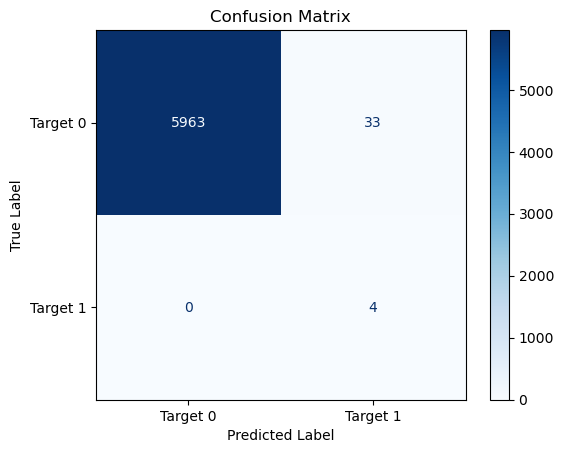

In [65]:
threshold = 0.2  
y_valid_pred_probs = (y_valid_pred_probs > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_valid_pred, y_valid_pred_probs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Target 0', 'Target 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Findings
AUC (Area Under the Curve): 0.554332
An AUC of 0.554332 is slightly better than random guessing, suggesting the model has limited discriminatory power.

Precision: 0.034753
This low precision indicates a high number of false positives.

Recall: 0.94898
This high recall suggests that the model is very good at identifying positive instances, but at the cost of predicting many false positives (low precision).

Accuracy: 0.137333
An accuracy of 0.137333 indicates that only 13.7333% of the total predictions are correct. This very low accuracy suggests that the model is not performing well overall, likely due to a significant class imbalance or a high number of false positives.

F1 Score: 0.067051
An F1 score of 0.067051 reflects the trade-off between the model's high recall and very low precision. The low F1 score indicates that the model's overall performance is poor.

In [61]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    title : string, title of the chart
    X : array-like, shape (n_samples, n_features), training vector
    y : array-like, shape (n_samples) or (n_samples, n_features), target values
    ylim : tuple, shape (ymin, ymax), Defines minimum and maximum yvalues plotted
    cv : int, cross-validation generator or an iterable
    n_jobs : int or None, optional (default=None), number of jobs to run in parallel
    train_sizes : array-like, shape (n_ticks,), percentage of training instances to generate learning curve
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-pack

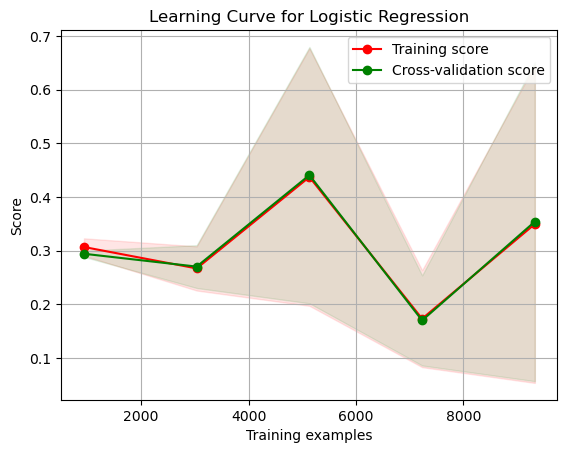

In [64]:
# Grid search for hyperparameter tuning
param_grid = {
    'preprocessing__pca__n_components': [5, 10, 15],
    'logistic__C': [0.1, 1.0, 10.0]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_imputed, y_train)


best_estimator = grid_search.best_estimator_

# Generate the learning curve
plot_learning_curve(estimator=best_estimator, title='Learning Curve for Logistic Regression',
                    X=X_train_imputed, y=y_train, cv=3, n_jobs=-1)

# Show plot
plt.show()


Conclusions:
The learning curve suggests that the current logistic regression model is underfitting the data, as indicated by the low accuracy scores and high variance in performance. 
With a small number of training examples , both the training and cross-validation scores are around 0.3. This indicates that the model is not performing well initially.
As the number of training examples increases, there are significant fluctuations in both the training and cross-validation scores. This could be due to various factors such as model instability or changes in the data distribution.
Towards the end (with around 9000 training examples), both the training and cross-validation scores converge to around 0.4. This indicates that the model's performance stabilizes as more training data is provided.